In [1]:
import numpy as np
from numpy.random import multinomial
from scipy.stats import dirichlet, multivariate_t, multivariate_normal
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

In [2]:
def data_gen(mu, cov, phi, n):
    """
    Generates samples from Mixture of K Multivariate Gaussian Distributions
    """
    y = np.empty((n, 2))
    z = []
    for i in range(n):
        ind = multinomial(1, phi)
        for j, val in enumerate(ind):
            if val == 1:
                z.append(j)
                y[i,:] = np.random.multivariate_normal(mu[j,:], cov[j,:,:])
            else:
                next
    return np.array(y), z

In [83]:
# Define parameters for K=3 Mixture of Multivariate Gaussians
phi = [.3, .5, .2]
mu = np.array([[13,5], [0,-2], [-14,3]])
cov_1 = np.array([[2.0, 0.3], [0.3, 0.5]])
cov_2 = np.array([[3.0,.4], [.4,3.0]])    
cov_3 = np.array([[1.7,-.7], [-.7,1.7]])
cov = np.stack((cov_1, cov_2, cov_3), axis = 0)


In [4]:
def collapsed_gibbs(data, a, v, K, iters = 500):
    N = data.shape[0]
    D = data.shape[1]
    assert v > D-1, "v must be greater than D-1"
    alpha = np.repeat(a, K)
    z = np.random.choice(K, size = N, replace = True, p =dirichlet(alpha / K).rvs().squeeze())
    for _ in range(iters):
        for i in range(N):
            # Remove x_i from data and Z
            d2 = np.delete(data, i, axis=0)
            z2 = np.delete(z, i, axis=0)
            p_z = []
            for k in range(K):
                mu_k = np.mean(d2[z2 == k], axis=0)
                # cov_k = np.cov(d2[z2 == k], rowvar=False)
                n_k = np.sum(z2 == k)
                p_z_k = (n_k + a/K) / (N + a - 1)
                S_k = np.dot(np.transpose(d2[z2 == k] - mu_k), d2[z2 == k] - mu_k) + np.eye(D)
                p_x_i = multivariate_t(mu_k, ((n_k+1) / (n_k *(n_k + v - D + 1)))*S_k, n_k+v - D + 1).pdf(data[i,])
                p_z_k = p_z_k * p_x_i
                p_z.append(p_z_k)
            # Standardize prob vector p(z_i = k)
            p_z = p_z / np.sum(p_z)
            z[i] = np.random.choice(K, 1, replace=True, p = p_z)

    return z



In [70]:
def collapsed_gibbs_IGMM(data, a, v, K, iters = 500):
    N = data.shape[0]
    D = data.shape[1]
    assert v > D-1, "v must be greater than D-1"
    alpha = np.repeat(a, K)
    z = np.random.choice(K, size = N, replace = True, p =dirichlet(alpha / K).rvs().squeeze())
    df = pd.DataFrame({"k": z, "p_z": np.nan})
    g_not = []
    for q in range(iters):
        for i in range(N):
            groups = list(np.unique(z))
            # Remove x_i from data and Z
            d2 = np.delete(data, i, axis=0)
            z2 = np.delete(z, i, axis=0)
            p_z = []
            g = []
            for k in groups:
                if np.sum([z2 == k]) == 0:
                    g_not.append(k)
                    # This is the last group so just move on
                    continue
                
                mu_k = np.mean(d2[z2 == k], axis=0)
                # cov_k = np.cov(d2[z2 == k], rowvar=False)
                n_k = np.sum(z2 == k)
                p_z_k = (n_k + a/K) / (N + a - 1)
                S_k = np.dot(np.transpose(d2[z2 == k] - mu_k), d2[z2 == k] - mu_k) + np.eye(D)
                p_x_i = multivariate_t(mu_k, ((n_k+1) / (n_k *(n_k + v - D + 1)))*S_k, n_k+v - D + 1).pdf(data[i,])
                p_z_k = p_z_k * p_x_i
                g.append(k)
                p_z.append(p_z_k)
            
            # Now consider new component
            p_z_k = (a / len(groups)) / (N + (a/len(groups)) - 1)
            p_x_i = multivariate_t([0 ,0], np.eye(D), v - D + 1).pdf(data[i,])
            p_z_k = p_z_k * p_x_i
            g.append(k+1)
            p_z.append(p_z_k)
            # Standardize prob vector p(z_i = k)
            p_z = p_z / np.sum(p_z)
            z[i] = np.random.choice(g, 1, replace=True, p = p_z)
        df = pd.DataFrame({
            'z': z,
        }).groupby(['z']).size().reset_index(name='counts')
        # Rename clusters to reindex to zero
        # z and z_new are the same thing, but z_new has cluster names from 0 - K
        # where z has cluster names > K. This can be a problem when using the cluster
        # name to subset a list of colors (which is why we rename them)
        lookup = df.to_dict()['z']
        lookup = dict((v,k) for k, v in lookup.items()) 
        z_new = np.array([lookup.get(i) for i in z])

        
    return z, df, z_new

[1]

In [ ]:
data, z = data_gen(mu, cov, phi, 500)
x, y = np.mgrid[-17:17.5:.1, -7:7.5:.1]
pos = np.dstack((x,y))


In [113]:
z_pred, df, z_new = collapsed_gibbs_IGMM(data, 1, 10, K=5, iters=50)

In [114]:
df

,z,counts
0,1,261
1,3,146
2,4,93


['red', 'blue', 'green', 'grey', 'yellow', 'black']


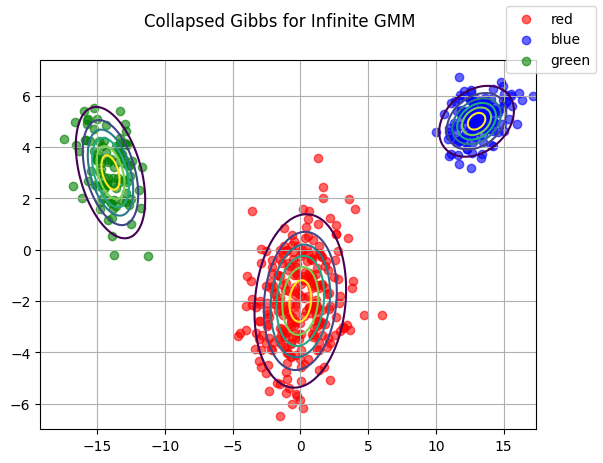

In [116]:
import matplotlib as mpl
mpl.style.use('default')
fig, ax = plt.subplots()
cols = ["red", "blue", "green", "grey", "yellow", "black"]
# Filter down to required colors. We assume we won't need more than 6
# given that we expect 3 clusters
cols1 = [cols[i] for i, v in enumerate(np.unique(z_new))]
print(cols)
for i, v in enumerate(cols1):
    d2 = data[np.array(z_new) == i,:]
    ax.scatter(d2[:,0], d2[:,1], color=v, alpha = .6, label = v)
    if i in range(3):
        ax.contour(x,y, multivariate_normal(mu[i,:], cov[i,:,:]).pdf(pos), extend='both')


fig.suptitle(f"Collapsed Gibbs for Infinite GMM, {df.shape[0]} Clusters Found")
ax.grid()
fig.legend()


<ipython-input-21-8130404423bb>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


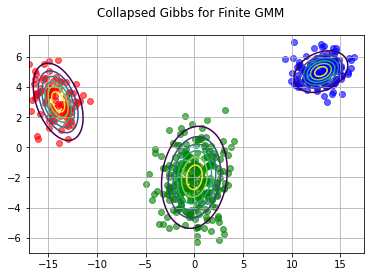

In [21]:
fig, ax = plt.subplots()
cols = ["red", "blue", "green"]
for i, v in enumerate(cols):
    d2 = data[np.array(z_pred) == i,:]
    ax.scatter(d2[:,0], d2[:,1], color=v, alpha = .6)
    ax.contour(x,y, multivariate_normal(mu[i,:], cov[i,:,:]).pdf(pos), extend='both')


fig.suptitle("Collapsed Gibbs for Finite GMM")
ax.grid()
fig.show()

## Prior Distributions

$$
\begin{align*}
p(\pmb{\pi}) & \sim Dir(\pmb{\alpha})\\
p(\pmb{\mu}_j) & \sim N(\pmb{\xi_j}, \frac{\Sigma_j}{\tau_j})\\
& \sim \frac{1}{\sqrt{(2\pi)^k \left| \frac{\Sigma_j}{\tau_j}\right|}}\exp^{-\frac{1}{2}(\pmb{\mu}_j - \pmb{\xi_j})^T\frac{\Sigma_j}{\tau_j}^{-1}(\pmb{\mu}_j - \pmb{\xi_j})}\\
p(\Sigma_j) & \sim W^{-1}(m_j, \pmb{\Psi_j})\\
& \sim \frac{\left|\pmb{\Psi_j}\right|^{\frac{m_j}{2}}}{2^{\frac{m_jp}{2}}\Gamma\left(\frac{m_j}{2}\right)}\left|\Sigma_j\right|^{-\frac{(m_j+p+1)}{2}}\exp^{-\frac{1}{2}}tr\left(\pmb{\Psi}\Sigma_j^{-1}\right)
\end{align*}
$$

## Complete Conditional for $p(\pmb{\mu})$

$$
\begin{align*}
p(\theta|x,z) & \propto p(x, z| \theta)p(\pmb{\pi})\prod_{j=1}^k\left[p(\pmb{\mu_j})p(\Sigma_j)\right]\\
& \propto \color{green}{\pi^{\sum_{i=1}^Nz_1}(1-\pi)^{\sum_{i=1}^Nz_2}} \prod_{i=1}^N\prod_{j=1}^K\phi_{\theta_j}(x_i)^{z_j}\prod_{j=1}^K\exp\left[-\frac{\mu_j^2}{2}\right]\left(\sigma^2_j\right)^{-2}\exp\left[-\frac{1}{\sigma^2_j}\right]\\
\end{align*}
$$

Now because we are working with bivariate normals instead of univariate normals, we have:
$$
\begin{align*}
\phi_j(x) & = \frac{1}{\sqrt{(2\pi)^k \left| \Sigma_j\right|}}\exp^{-\frac{1}{2}(\pmb{x} - \pmb{\mu_j})^T\Sigma^{-1}(\pmb{x} - \pmb{\mu_j})}
\end{align*}
$$
